In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import json
import itertools
import collections

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import manifold

In [3]:
import random_indexing as ri

In [7]:
def read_tweets(f_name):
    with open(f_name) as f:
        csv_reader = csv.reader(f)
        next(csv_reader)
        for line in csv_reader:
            tweet_id, text, language, screen_names, hashtags, is_retweet = line
            tweet_id = int(tweet_id)
            screen_names = json.loads(screen_names)
            hashtags = json.loads(hashtags)
            is_retweet = bool(is_retweet)
            
            yield tweet_id, text, language, screen_names, hashtags, is_retweet

In [9]:
vocabulary = collections.OrderedDict(
    collections.Counter(itertools.chain.from_iterable(r[1] for r in read_tweets('tweet_dump.csv')))
    .most_common()
)

vocabulary[''] = 0

In [10]:
len(vocabulary)

4679

In [11]:
features = ri.Features(vocabulary)

In [15]:
# TODO: don't index retweets. Only add them to the screen_names collection.
# TODO: store vectors for tweets.
def index(tweets, features):
    languages = collections.OrderedDict(), collections.Counter()
    screen_names = collections.OrderedDict(), collections.Counter()
    hashtags = collections.OrderedDict(), collections.Counter()

    def update(vector, collection_counter, keys):
        collection, counter = collection_counter
        counter.update(keys)
        
        for key in keys:
            if key in collection:
                collection[key] += vector
            else:
                collection[key] = vector    
    
    for (tweet_id, text, language, sns, hts, is_retweet) in tweets:
        tweet_vector = np.stack(ri.vectorize(text, window_length=3, features=features)).prod(axis=0)

        if not is_retweet:
            update(tweet_vector, languages, [language])
            update(tweet_vector, hashtags, hts)

        update(tweet_vector, screen_names, sns)
    
    def df(collection_counter):
        collection, counter = collection_counter
        return pd.DataFrame(np.stack(collection.values()), index=collection.keys()), counter
    
    return df(languages), df(screen_names), df(hashtags)

In [23]:
%%time
languages, screen_names, hashtags = index(
    itertools.islice(read_tweets('tweet_dump.csv'), None),
    features,
)

CPU times: user 2h 10min 54s, sys: 18min 6s, total: 2h 29min 1s
Wall time: 2h 29min 12s


In [ ]:
# f, ax = plt.subplots(figsize=(20,15))

# sns.heatmap(
#     pd.DataFrame(
#         pairwise_distances(languages, metric='cosine'),
#         index=languages.index,
#         columns=languages.index,
#     ),
#     annot=True,
#     square=True,
#     fmt='0.1f',
#     ax=ax
# );

In [32]:
def plot(entities, figsize=(20, 10), tracked_only=False):
    mds = manifold.MDS(metric=False, dissimilarity='precomputed', n_jobs=2)
    mds = manifold.TSNE()

    xy = pd.DataFrame(
        mds.fit_transform(
#             entities,
            pairwise_distances(entities, metric='cosine'),
        ),
        index=entities.index,
    )

    ax = xy.plot.scatter(x=0, y=1, figsize=figsize)

    xy.apply(lambda r: ax.text(r[0], r[1], r.name if not tracked_only or isinstance(r.name, str) else ''), axis=1)
    
    return ax

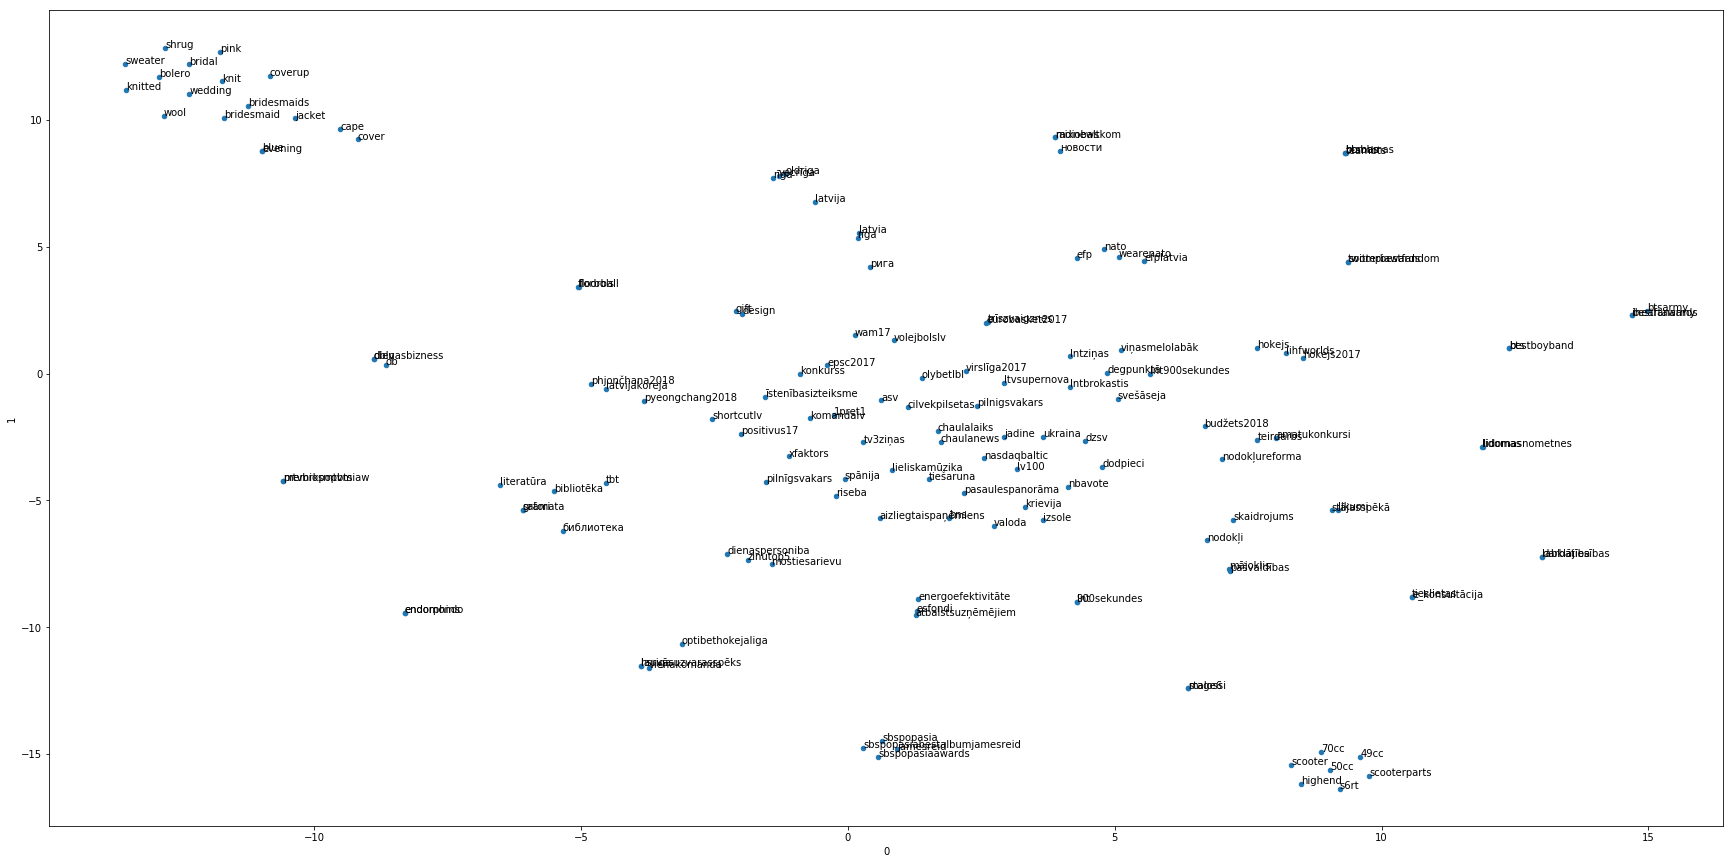

In [34]:
plot(hashtags[0].loc[[k for  k, _ in hashtags[1].most_common(150)]], figsize=(30, 15));

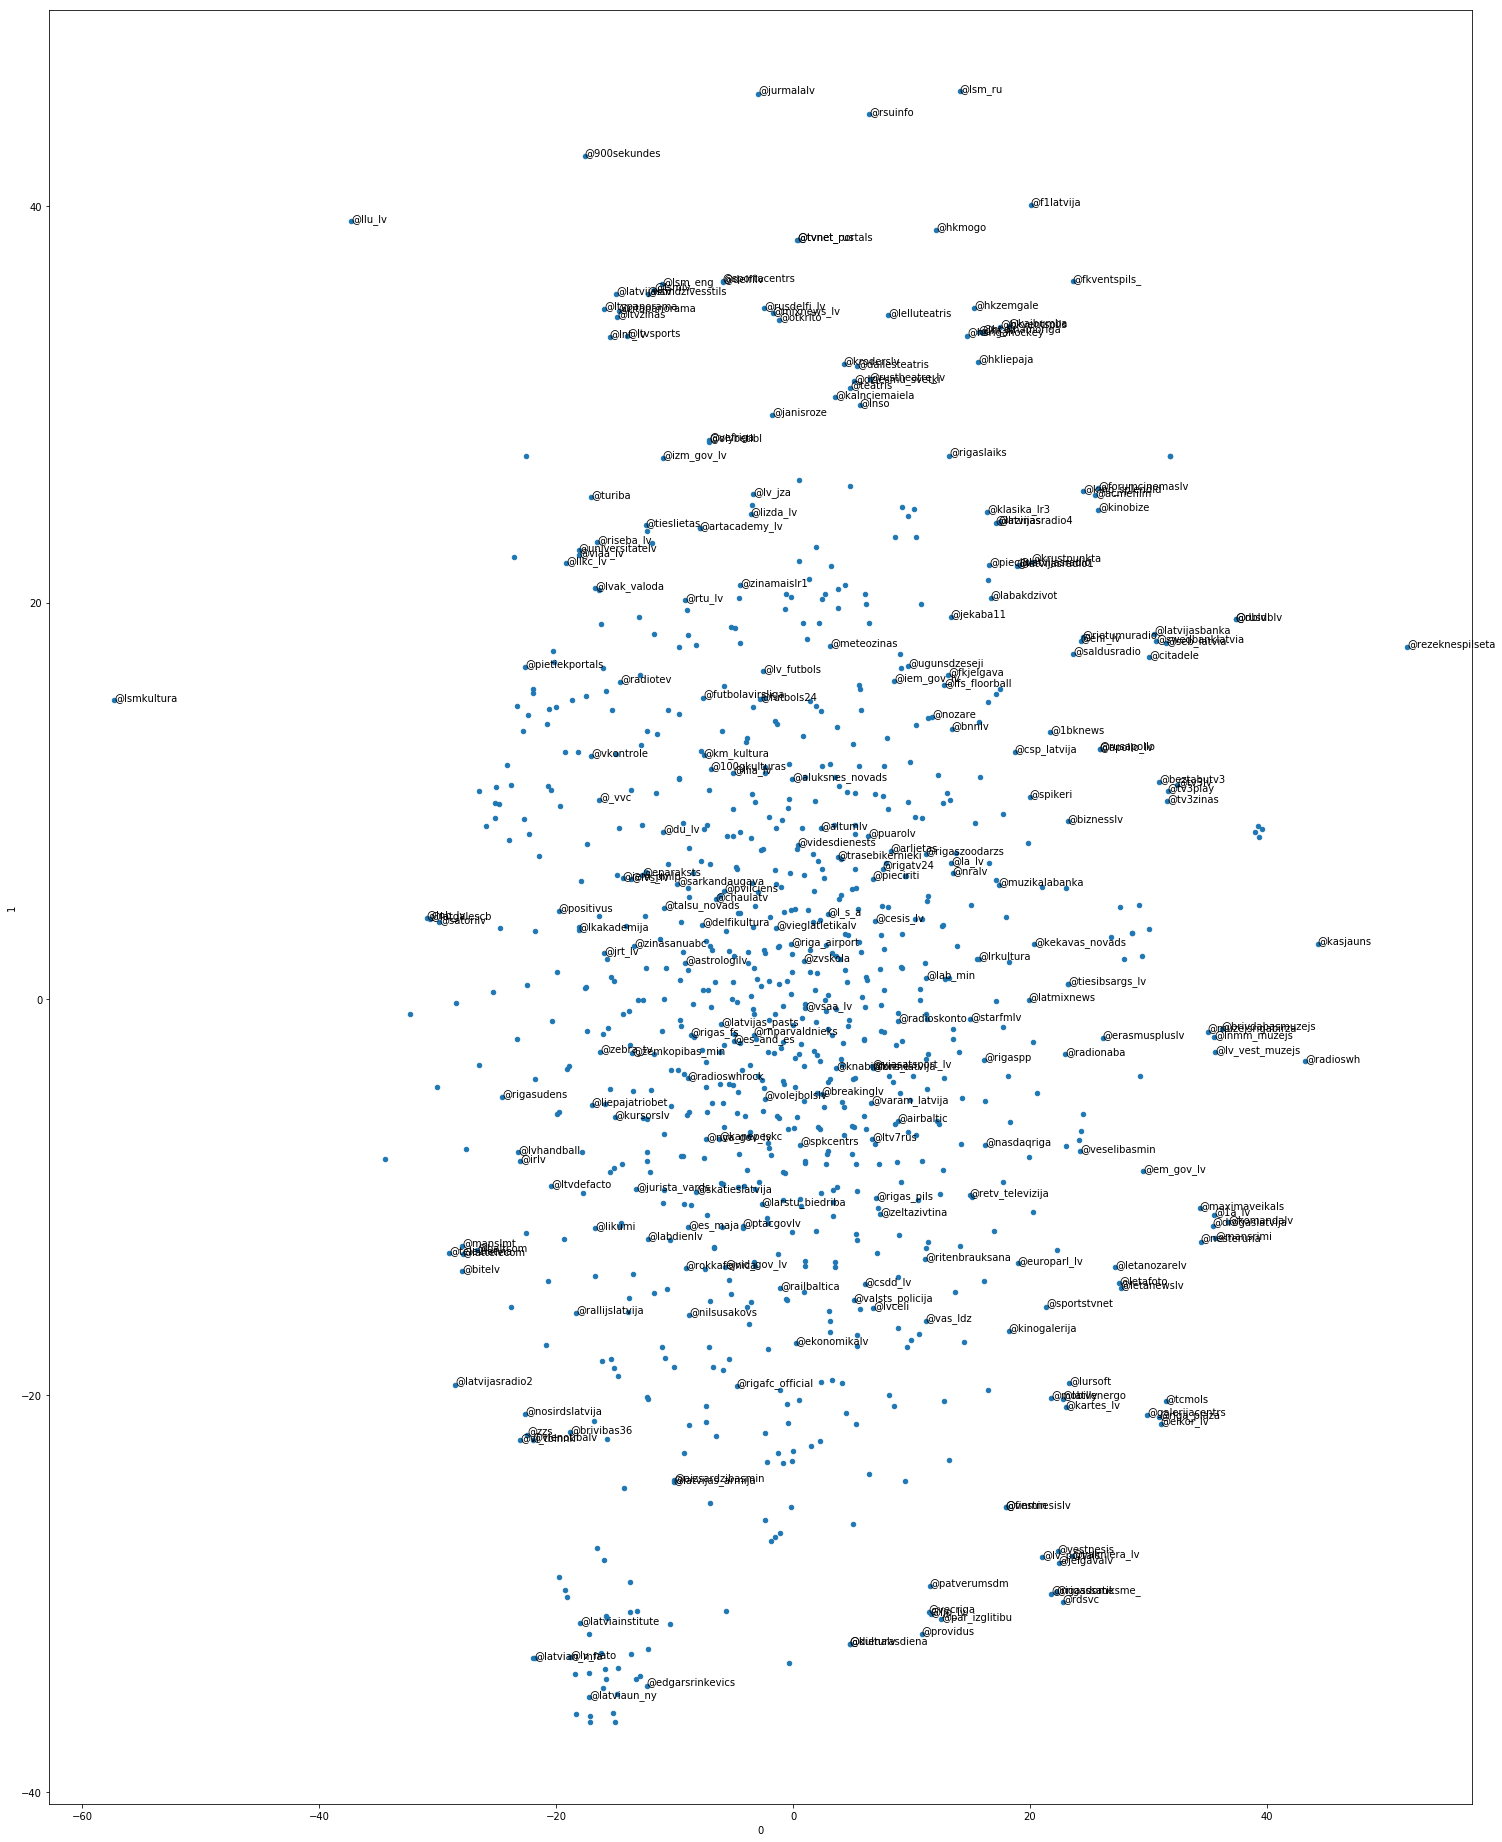

In [42]:
ax = plot(
    screen_names[0].loc[[k for  k, _ in screen_names[1].most_common(1000) if not str(k).startswith('@@')]],
    figsize=(8.5 * 3, 11 * 3),
    tracked_only=True,
)

ax.figure.savefig('screen_names.pdf')

In [43]:
!open .

In [28]:
def export_to_tf(collection, prefix):
    collection.to_csv(f'features-{prefix}.csv', sep='\t', index=False, header=False)
    collection.index.to_series().to_csv(f'metadata-{prefix}.csv', index=False)

In [29]:
export_to_tf(screen_names[0], 'screen_names')

In [30]:
export_to_tf(hashtags[0], 'hashtags')

In [31]:
export_to_tf(languages[0], 'languages')